In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lb-195/submission.csv
/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv
/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv


In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
print("Train shape", train.shape )
train.head()

Train shape (2190, 13)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [3]:
test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
print("Test shape:", test.shape )
test.head()

Test shape: (730, 12)


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [4]:
RMV = ['rainfall','id']
FEATURES = [c for c in train.columns if not c in RMV]
print("Our features are:")
print( FEATURES )

Our features are:
['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


In [5]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)

Using XGBoost version 2.0.3


In [6]:
%%time
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"rainfall"]    
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"rainfall"]
    x_test = test[FEATURES].copy()

    model = XGBClassifier(
        max_depth=6,  
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=10_000,  
        learning_rate=0.1, 
        eval_metric="auc",
        early_stopping_rounds=100,
        alpha=1,
    )
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100 
    )

    # INFER OOF
    oof_xgb[test_index] = model.predict_proba(x_valid)[:,1]
    # INFER TEST
    pred_xgb += model.predict_proba(x_test)[:,1]

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-auc:0.84830
[100]	validation_0-auc:0.86668
[149]	validation_0-auc:0.86223
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.86713
[100]	validation_0-auc:0.87534
[124]	validation_0-auc:0.87287
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.87075
[100]	validation_0-auc:0.90394
[164]	validation_0-auc:0.90044
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.90608
[100]	validation_0-auc:0.91653
[115]	validation_0-auc:0.91404
#########################
### Fold 5
#########################
[0]	validation_0-auc:0.84984
[100]	validation_0-auc:0.87461
[131]	validation_0-auc:0.87474
CPU times: user 4.49 s, sys: 69.5 ms, total: 4.56 s
Wall time: 1.24 s


In [7]:
from sklearn.metrics import roc_auc_score
true = train.rainfall.values
m = roc_auc_score(true, oof_xgb)
print(f"XGBoost CV Score AUC = {m:.3f}")

XGBoost CV Score AUC = 0.881


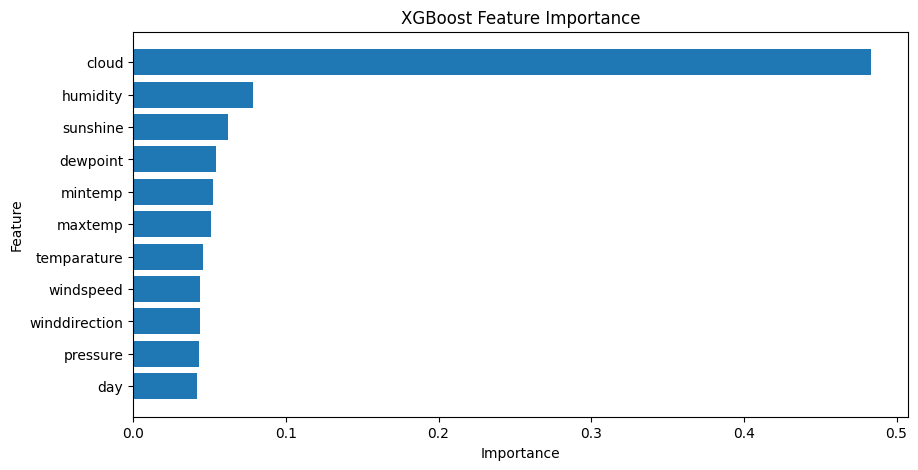

In [8]:
import matplotlib.pyplot as plt
feature_importance = model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  
plt.show()

In [9]:
print("Best Public Notebook achieves LB = 0.915!")
best_public = pd.read_csv("/kaggle/input/lb-195/submission.csv")
display( best_public.head() )
best_public = best_public.rainfall.values

Best Public Notebook achieves LB = 0.915!


,id,rainfall
0,2190,0.978408
1,2191,0.983057
2,2192,0.812125
3,2193,0.160289
4,2194,0.091565


In [10]:
from scipy.stats import rankdata

print("Ensemble achieves LB = 0.935! Hooray!")
sub = pd.read_csv("/kaggle/input/playground-series-s5e3/sample_submission.csv")
sub.rainfall = -1 * rankdata( pred_xgb ) + 2 * rankdata( best_public )
sub.rainfall = rankdata( sub.rainfall ) / len(sub)
print( sub.shape )
sub.to_csv(f"submission.csv",index=False)
sub.head()

Ensemble achieves LB = 0.935! Hooray!
(730, 2)


,id,rainfall
0,2190,0.869178
1,2191,0.908904
2,2192,0.304110
3,2193,0.081507
4,2194,0.015753
